<a href="https://colab.research.google.com/github/yang-song/score_sde/blob/main/Score_SDE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

1. `git clone https://github.com/yang-song/score_sde.git`

2. Install [required packages](https://github.com/yang-song/score_sde/blob/main/requirements.txt)

3. `cd` into folder `score_sde`, launch a local jupyter server and connect to colab following [these instructions](https://research.google.com/colaboratory/local-runtimes.html)

4. Download pre-trained [checkpoints](https://drive.google.com/drive/folders/1RAG8qpOTURkrqXKwdAR1d6cU9rwoQYnH?usp=sharing) and save them in the `exp` folder.

In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import matplotlib
import importlib
import os
import functools
import itertools
import jax.random as random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import inspect

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import run_lib

import sampling
import losses as losses_lib
import utils
import evaluation
from models import up_or_down_sampling as stylegan_layers
import datasets
from models import wideresnet_noise_conditional
import sde_lib
import likelihood
import controllable_generation

from sampling import *
from sde_lib import *
from scipy import integrate

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/qzhang419/.local/lib/python3.8/site-packages/flax/nn/__init__.py:35: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


In [2]:
# @title Load the score-based model

from configs.vp import cifar10_ddpmpp_continuous as configs

# TODO: change ckpt path
ckpt_filename = os.path.expanduser("~/projects/dodes/ckpts/cifar10_ddpmpp_continuous_l")
assert os.path.exists(ckpt_filename)
config = configs.get_config()
sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3

batch_size =   64#@param {"type":"integer"}
local_batch_size = batch_size // jax.local_device_count()
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
rng, run_rng = jax.random.split(rng)
rng, model_rng = jax.random.split(rng)
score_model, init_model_state, initial_params = mutils.init_model(run_rng, config)
optimizer = losses_lib.get_optimizer(config).create(initial_params)

state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                      model_state=init_model_state,
                      ema_rate=config.model.ema_rate,
                      params_ema=initial_params,
                      rng=rng)  # pytype: disable=wrong-keyword-args
sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
state = utils.load_training_state(ckpt_filename, state)

In [3]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


In [4]:
rng = random.PRNGKey(888)
noise = random.normal(rng, (100, 32, 32, 3))

## play deis

In [5]:
import jax_deis as jdeis

In [6]:
t2alpha_fn, alpha2t_fn = jdeis.get_linear_alpha_fns(sde.beta_0, sde.beta_1)
vpsde = jdeis.VPSDE(t2alpha_fn, alpha2t_fn, sampling_eps, sde.T)

In [7]:
score_fn = mutils.get_score_fn(sde, score_model, state.params_ema, state.model_state, train=False, continuous=True)
def eps_fn(x, scalar_t):
  vec_t = scalar_t * jnp.ones(x.shape[0])
  score = score_fn(x, vec_t)
  std = sde.marginal_prob(jnp.zeros_like(score), vec_t)[1]
  eps = - batch_mul(score, std)
  return eps

In [8]:
num_step = 7
t_ab_fn = jdeis.get_sampler(vpsde, eps_fn, "t", 2, num_step, method="t_ab", ab_order=3)

In [9]:
t_ab_7_img = t_ab_fn(noise)

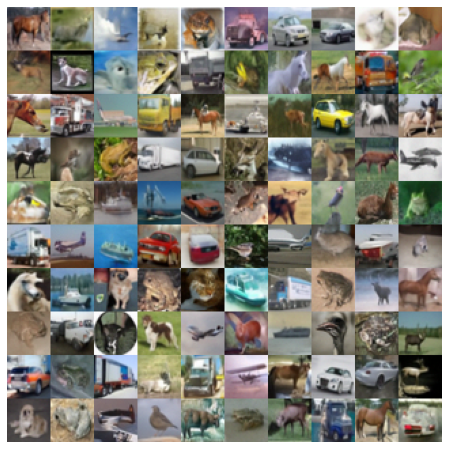

In [10]:
show_samples(inverse_scaler(t_ab_7_img))

In [11]:
rho_ab_7_fn = jdeis.get_sampler(vpsde, eps_fn, "t", 2, num_step, method="rho_ab", ab_order=3)
rho_ab_7_img = rho_ab_7_fn(noise)

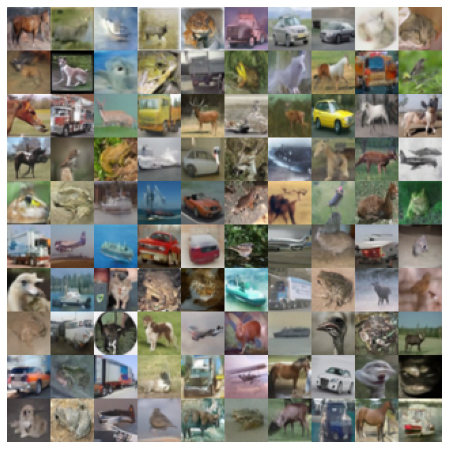

In [12]:
show_samples(inverse_scaler(rho_ab_7_img))

In [13]:
rho_rk_7_fn = jdeis.get_sampler(vpsde, eps_fn, "t", 2, 7, method="rho_rk", rk_method="3kutta") # it actually use 7 * 3 = 21 NFE
rho_rk_7_img = rho_rk_7_fn(noise)

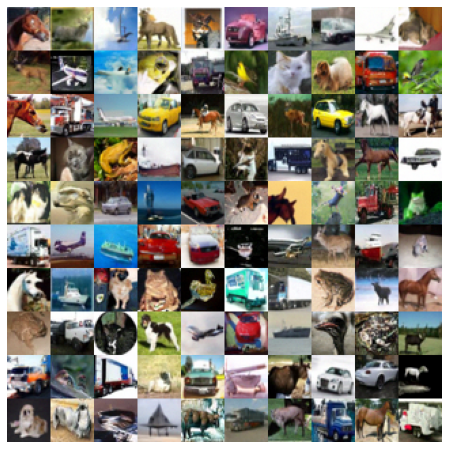

In [14]:
show_samples(inverse_scaler(rho_rk_7_img))